### Building and Evaluating ARMA Models

The main task here is to pick a time series of interest, fit an ARMA model to it, make a basic forecast, and then assess
how well it performs by analyzing the errors. It’s also a good idea to experiment with a few different combinations of
$p$ and $q$, since ACF and PACF plots are only rough guides. Running a small grid search often helps find better parameter values.

For this exercise, I worked with the [Production and sales of cement bags](https://indicadores.pr/dataset/f1b1d002-5958-431a-abfe-539ce3814018/resource/806d9de9-c2ee-4506-b6fc-ed2990a54561/download/datos_cemento.csv)
, which contains monthly data on the production and sales of 94 lb sacks of cement in Puerto Rico.


## Production and sales of cement bags
#### Data Description:
The data contains three columns: `Date`, `Production`, and `Sales`. For this exercise, I will focus on forecasting the `Sales` column, which represents the number of cement bags sold each month. The goal is to build an ARMA, ARIMA, SARIMA, or SARIMAX model to forecast future sales and evaluate the model's performance.

The `Production` recording started in January 2007  and the `Sales` recording started in July 1998. For this exercise, I will work from data starting in January 2007, which gives us a consistent time frame for both production and sales.

**Source:** Government Development Bank (BGF).

Since 1959, the BGF has collected monthly information on the production and sales of companies that produce 94‑pound cement bags in Puerto Rico. At present, these are: CEMEX, ESSROC, and Argos. This information is aggregated and published by the BGF. Note: Sales of cement bags that occur in retail stores are not included, nor are cement bags imported into Puerto Rico included.


## Time Series Models

The first step is to load the data and preprocess it, including handling any missing values and ensuring that the date column is in the correct format for time series analysis. After that, I will explore the data, visualize it, and then proceed to fit different models to the sales data. Finally, I will evaluate the model's performance using appropriate metrics such as mean squared error (MSE) and mean absolute error (MAE).

To summarize, the steps are as follows:
1. Load and preprocess the data.
2. Explore and visualize the sales data.
3. Fit multiple models to the sales data.
4. Make forecasts of Sales using the fitted model.
5. Evaluate the model's performance using MSE and MAE.

In [78]:
# Import Libraries

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from openpyxl.styles.builtins import title

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Suppress SettingWithCopyWarning
pd.options.mode.chained_assignment = None

In [79]:
# Load data train data
df = pd.read_csv('./data/datos_cemento.csv')
df.head()


,Date,Production,Sales
0,12/1/2025,673242.0,1175442.649
1,11/1/2025,731303.0,1176428.391
2,10/1/2025,779872.0,1386078.940
3,9/1/2025,634802.0,1229262.336
4,8/1/2025,812366.0,1324978.434


In [80]:
df.tail()

,Date,Production,Sales
325,11/1/1998,NaN,3259000.0
326,10/1/1998,NaN,3070000.0
327,9/1/1998,NaN,2447000.0
328,8/1/1998,NaN,3258000.0
329,7/1/1998,NaN,3700000.0


### Preprocessing

In [81]:
# production started in Jan 2007.
df.isna().sum()

Date            0
Production    102
Sales           0
dtype: int64

In [82]:
# Drop na values
df.dropna(inplace=True)

In [83]:
df.isna().sum()

Date          0
Production    0
Sales         0
dtype: int64

In [84]:
# Should have data starting in Jan 2007
print(df.head())
print(df.tail())

        Date  Production        Sales
0  12/1/2025    673242.0  1175442.649
1  11/1/2025    731303.0  1176428.391
2  10/1/2025    779872.0  1386078.940
3   9/1/2025    634802.0  1229262.336
4   8/1/2025    812366.0  1324978.434
         Date  Production      Sales
223  5/1/2007   2912950.0  3535506.0
224  4/1/2007   2438980.0  2874418.0
225  3/1/2007   3242360.0  3530070.0
226  2/1/2007   2810360.0  3103919.0
227  1/1/2007   2338910.0  2896660.0


In [85]:
# Change date column to datetime and update index to Date
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
# Sort descending order by date
df.sort_index(inplace=True)
# Set frequency
df.index.freq = 'MS' # Monty Start
df

,Production,Sales
Date,,
2007-01-01,2338910.0,2896660.000
2007-02-01,2810360.0,3103919.000
2007-03-01,3242360.0,3530070.000
2007-04-01,2438980.0,2874418.000
2007-05-01,2912950.0,3535506.000
...,...,...
2025-08-01,812366.0,1324978.434
2025-09-01,634802.0,1229262.336
2025-10-01,779872.0,1386078.940


#### Sales and Production Distribution

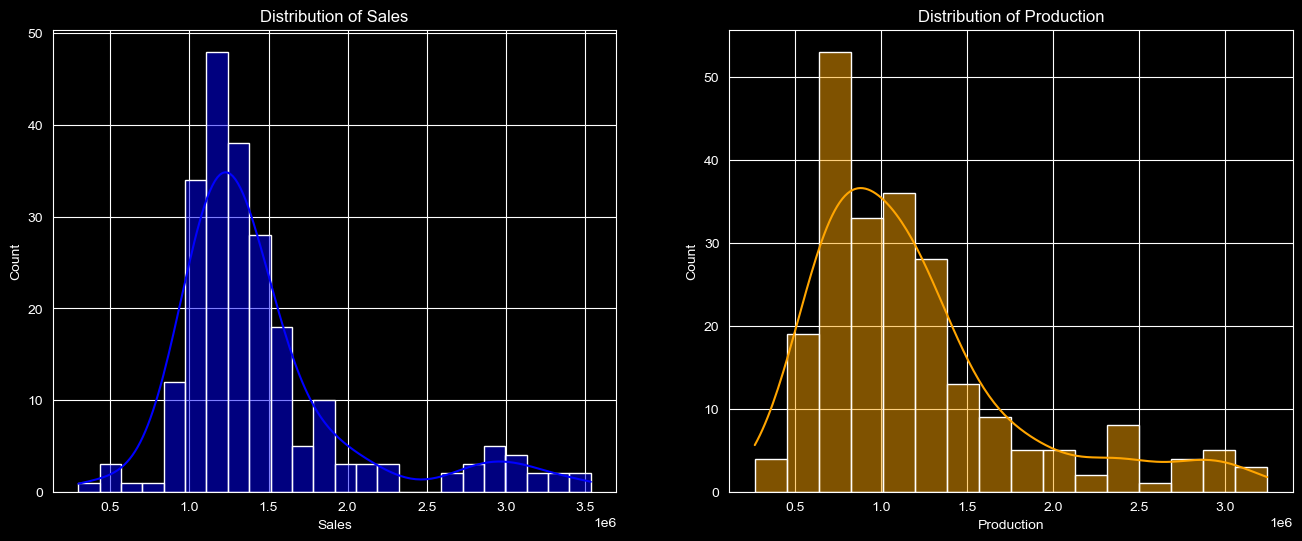

In [86]:
 # Plot sales and production distribution
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(df['Sales'], ax=ax[0], kde=True, color='blue')
ax[0].set_title('Distribution of Sales')
sns.histplot(df['Production'], ax=ax[1], kde=True, color='orange')
ax[1].set_title('Distribution of Production')
plt.show()

#### Interpretation

The distribution of sales appears to be right-skewed, with a long tail towards higher sales values. This suggests that there are some months with significantly higher sales compared to the majority of the data. The distribution of production also appears to be right-skewed, but it is less pronounced than the sales distribution. Both distributions indicate that there may be outliers or extreme values in the data, which could impact the modeling process. It may be necessary to consider log tranformation technique to handle the skewness in the data before fitting the models.

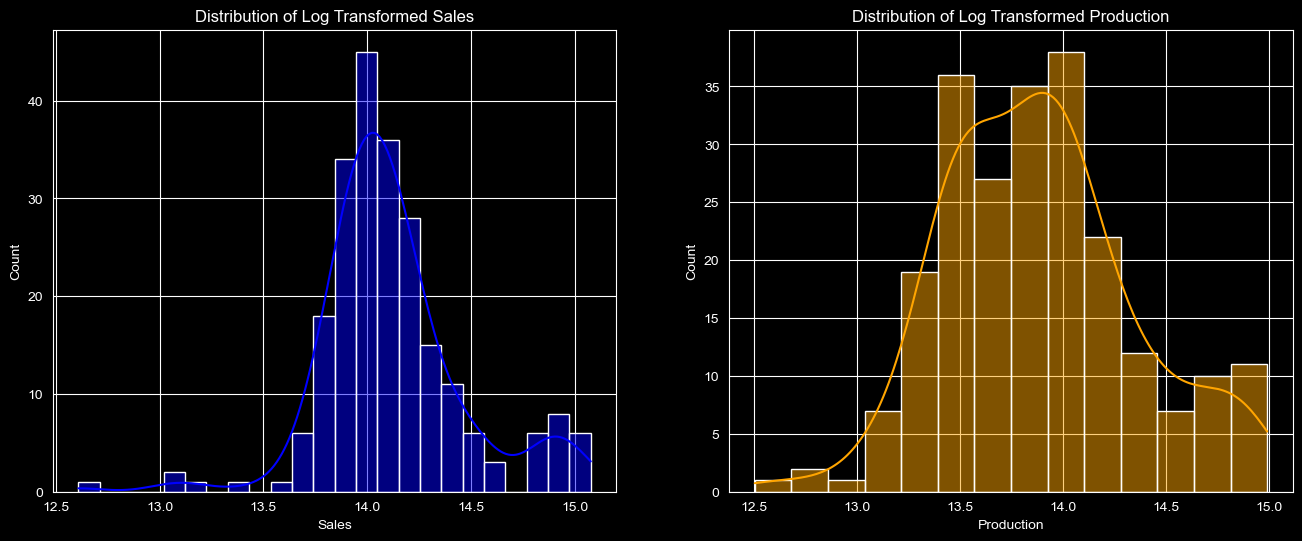

In [87]:
# Apply log transformation to handle skewness
# Plot log transformed sales and production distribution
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(np.log(df['Sales']), ax=ax[0], kde=True, color='blue')
ax[0].set_title('Distribution of Log Transformed Sales')
sns.histplot(np.log(df['Production']), ax=ax[1], kde=True, color='orange')
ax[1].set_title('Distribution of Log Transformed Production')

plt.show()

#### Interpretation

The distribution of log transformed sales appears to be more symmetric shape. This suggests that the log transformation has effectively reduced the skewness in the sales data. The distribution of log transformed production also appears to be more symmetric, but it is still slightly skewed to the right. This indicates that the log transformation has helped to stabilize the variance in the production data, which can be beneficial for modeling.

#### Split data into train and test sets

Data from Jan 2007 to Dec 2020 will be used for training, and data from Jan 2021 to Dec 2025 will be used for testing. This allows us to evaluate the model's performance on unseen data while still having a significant amount of data for training.

In [88]:
df.tail()

,Production,Sales
Date,,
2025-08-01,812366.0,1324978.434
2025-09-01,634802.0,1229262.336
2025-10-01,779872.0,1386078.940
2025-11-01,731303.0,1176428.391
2025-12-01,673242.0,1175442.649


In [89]:
#### Split data into train and test sets
df_train = df[df.index < '2021-01-01']
df_test = df[df.index >= '2021-01-01']
print(f'Training data range: {df_train.index.min()} to {df_train.index.max()}')
print(f'Testing data range: {df_test.index.min()} to {df_test.index.max()}')

Training data range: 2007-01-01 00:00:00 to 2020-12-01 00:00:00
Testing data range: 2021-01-01 00:00:00 to 2025-12-01 00:00:00


### Exploratory Data Analysis

In [90]:
# Function to plot sales
def sales_plot(new_df=None, column='Sales', title='Monthly Sales of Cement Bags in Puerto Rico',
               xaxis_title='Date', yaxis_title='Number of Cement Bags Sold'):
    fig = go.Figure()

    # plot new df
    if new_df is not None:
        fig.add_trace(go.Scatter(
            x=new_df.index,
            y=new_df[column],
            mode='lines+markers',
            line=dict(color='#EF553B'),
            marker=dict(color='#EF553B'),
            name=column))

    # plot original Sales column
    fig.add_trace(go.Scatter(
        x=df_train.index,
        y=df_train['Sales'],
        mode='lines+markers',
        name='Sales',
        line=dict(color='#636EFA'),
        marker=dict(color='#636EFA')))

    # plot config
    fig.update_layout(
        title=title,
        xaxis_title=xaxis_title,
        yaxis_title=yaxis_title,
        template='plotly_white',
        hovermode='x'
    )

    fig.show()


In [91]:
sales_plot(None)

In [92]:
# Plot log transformed sales

fig = go.Figure()

# plot original Sales column
fig.add_trace(go.Scatter(
    x=df_train.index,
    y=np.log(df_train['Sales']),
    mode='lines+markers',
    name='Log(Sales)',
    line=dict(color='#636EFA'),
    marker=dict(color='#636EFA')))

# plot config
fig.update_layout(
    title='Log(Monthly Sales of Cement Bags in Puerto Rico)',
    xaxis_title='Date',
    yaxis_title='Log of Sales',
    template='plotly_white',
    hovermode='x'
)

fig.show()


#### Interpretation
This series shows trends and seasonality indicating non stationary, may need to consider differencing or seasonal components in our model. Will do stationarity test using the Augmented Dickey-Fuller test (ADF test) and also look at the ACF and PACF plots to determine potential values for p and q.

### Stationarity Test (ADF Test)

In [93]:
# ADF test on raw data
adf_stat, p_value, *_ = adfuller(df_train['Sales'])
print(f'ADF Statistic raw data: {adf_stat}')
print(f'p-value raw data: {p_value}')
print('***')
# ADF test on log transformed data
adf_stat_log, p_value_log, *_ = adfuller(np.log(df_train['Sales']))
print(f'ADF Statistic for log transformed data: {adf_stat_log}')
print(f'p-value for log transformed data: {p_value_log}')

ADF Statistic raw data: -3.5088977762165423
p-value raw data: 0.007761499246456593
***
ADF Statistic for log transformed data: -2.7209981462880544
p-value for log transformed data: 0.07047462177160226


### Interpretation
The p value for raw data is 0.0078, p < 0.05, the test rejects the null hypothesis, the series is stationary. The p value for log transformed data is 0.07, p > 0.05, the test fails to reject the null hypothesis, the log transformed series is not stationary. I will proceed with the raw data for modeling since it is already stationary.

#### ACF and PACF Analysis

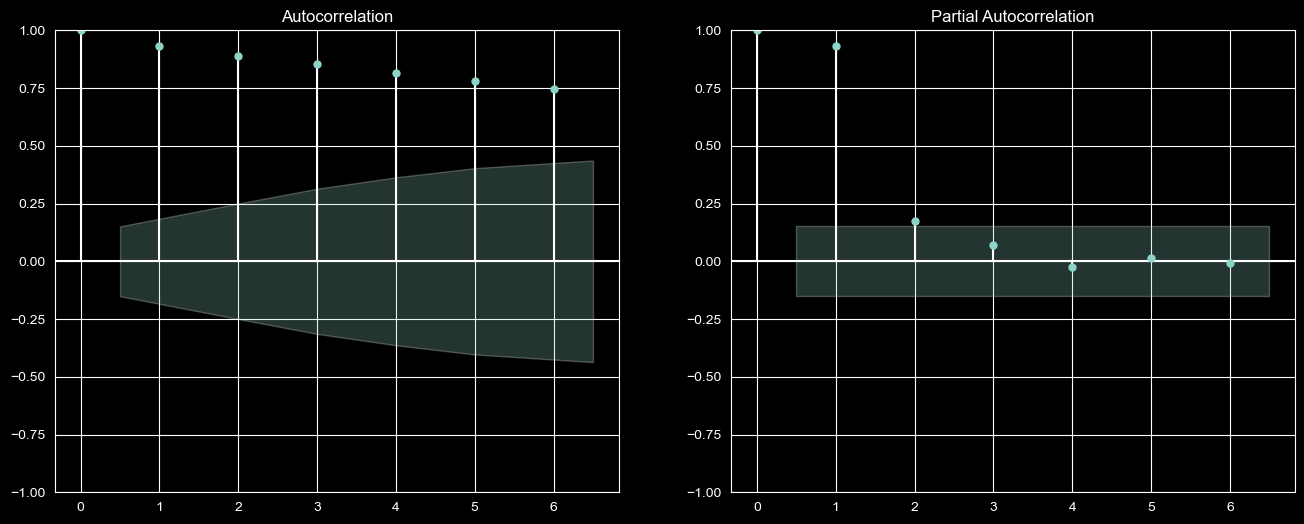

In [117]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(df_train['Sales'], ax=ax[0], lags=6)
plot_pacf(df_train['Sales'], ax=ax[1], lags=6,)

plt.show()


#### Interpretation

The ACF starts high at lag 1 and then slowly decreases. This slow decay indicates an autoregressive (AR) process, where past values influence future values beyond just lag 1. The PACF shows a significant spike at lag 1 and then cuts off sharply, which suggest and AR(1) process, the current value is strongly dependent on the immediately previous value, but not on values further back in time. Based on this analysis, I will start by fitting an AR(1) model to the sales data and evaluate its performance.


#### Rules for identifying p and q from ACF and PACF plots

| ACF Pattern | PACF Pattern | Model | p | q |
|---|---|---|---|---|
| Sharp cutoff after lag *q* | Slow/gradual decay | Pure MA(q) | 0 | Number of significant ACF lags |
| Slow/gradual decay | Sharp cutoff after lag *p* | Pure AR(p) | Number of significant PACF lags | 0 |
| Sharp cutoff after lag *q* | Sharp cutoff after lag *p* | Mixed ARMA(p,q) | Number of significant PACF lags | Number of significant ACF lags |`
| Both decay gradually | Both decay gradually | Mixed ARMA(p,q) | Try small values & compare AIC/BIC | Try small values & compare AIC/BIC |
| Both cut off at lag 0 | Both cut off at lag 0 | White noise | 0 | 0 |

Based on this analysis, I will start by fitting an `ARMA(p,q)`=`ARMA(1,0)`= `ARIMA(1,0,0)`= `ARIMA(p,d,q)` model to the differenced sales data and evaluate its performance.

Below table is a summary of the different models I will fit to the data, along with their corresponding parameters and the data used for fitting:

| ARIMA Model | p | d | q | Data Used                         | Stationarity Condition                              |
|:-----------:|:-:|:-:|:-:|:---------------------------------:|:---------------------------------------------------:|
| AR          | 1 | 0 | 0 | Original (Sales)                  | Stationary (ADF p-value = 0.008, no differencing)    |
| MA          | 0 | 0 | 1 | Original (Sales)                  | Stationary (ADF p-value = 0.008, no differencing)    |
| ARMA        | 2 | 0 | 1 | Original (Sales)                  | Stationary (ADF p-value = 0.008, no differencing)    |
| ARIMA       | 2 | 1 | 2 | Original (Sales)                  | Model applies 1 order of differencing (d=1)          |
| ARIMAX      | 2 | 1 | 2 | Original + Exogenous (Production) | Model applies 1 order of differencing (d=1)          |
| SARIMA      | 2 | 1 | 2 | Original (Sales)                  | Model applies 1 order of differencing (d=1)          |
| SARIMAX     | 2 | 1 | 2 | Original + Exogenous (Production) | Model applies 1 order of differencing (d=1)          |

#### ARIMA Models Fitting and Evaluation

##### AR(1) Model using ARIMA(1,0,0)

In [120]:
ar_model = ARIMA(df_train['Sales'], order=(1, 0, 0))
ar_result = ar_model.fit()
print(ar_result.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  168
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2304.157
Date:                Mon, 09 Feb 2026   AIC                           4614.315
Time:                        22:04:40   BIC                           4623.687
Sample:                    01-01-2007   HQIC                          4618.118
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.521e+06   2.84e+05      5.350      0.000    9.64e+05    2.08e+06
ar.L1          0.9498      0.018     52.262      0.000       0.914       0.985
sigma2      4.626e+10      2.477   1.87e+10      0.0